<a href="https://colab.research.google.com/github/cormach/bayesian_stats_by_b_lambert/blob/master/Chapter_16_question_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import json
import shutil
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Please use the latest version of CmdStanPy
!pip install --upgrade cmdstanpy

ERROR: fbprophet 0.6 has requirement cmdstanpy==0.4, but you'll have cmdstanpy 0.9.5 which is incompatible.
  Found existing installation: cmdstanpy 0.4.0
    Uninstalling cmdstanpy-0.4.0:
      Successfully uninstalled cmdstanpy-0.4.0


In [4]:
# Install pre-built CmdStan binary
# (faster than compiling from source via install_cmdstan() function)
tgz_file = 'colab-cmdstan-2.23.0.tar.gz'
tgz_url = 'https://github.com/stan-dev/cmdstan/releases/download/v2.23.0/colab-cmdstan-2.23.0.tar.gz'
if not os.path.exists(tgz_file):
    urllib.request.urlretrieve(tgz_url, tgz_file)
    shutil.unpack_archive(tgz_file)

In [5]:
# Specify CmdStan location via environment variable
os.environ['CMDSTAN'] = './cmdstan-2.23.0'
# Check CmdStan path
from cmdstanpy import CmdStanModel, cmdstan_path
cmdstan_path()

'./cmdstan-2.23.0'

In [6]:
!pip install arviz

     |████████████████████████████████| 1.5MB 2.6MB/s 
     |████████████████████████████████| 4.1MB 13.2MB/s 
     |████████████████████████████████| 296kB 38.1MB/s 


In [7]:
import arviz as az

Question 16_1 - discoveries

In [ ]:
stan_text = '''data {
    int N;
    int<lower=0> X[N];
}
parameters {
    real<lower=0> mu;
    real<lower=0> kappa;
}
model {
    X ~ neg_binomial_2(mu, kappa);
    mu ~ lognormal(2,1);
    kappa ~lognormal(2,1);    
}
generated quantities {
  int<lower=0> XSim[N];
  for (i in 1:N)
  {XSim[i] <- neg_binomial_2_rng(mu, kappa);}
}'''
with open('stan_file.stan', 'w') as f:
  f.write(stan_text)

In [ ]:
!cat stan_file.stan

data {
    int N;
    int<lower=0> X[N];
}
parameters {
    real<lower=0> mu;
    real<lower=0> kappa;
}
model {
    X ~ neg_binomial_2(mu, kappa);
    mu ~ lognormal(2,1);
    kappa ~lognormal(2,1);    
}
generated quantities {
  int<lower=0> XSim[N];
  for (i in 1:N)
  {XSim[i] <- neg_binomial_2_rng(mu, kappa);}
}

In [ ]:
stan_model = CmdStanModel(stan_file='stan_file.stan')

INFO:cmdstanpy:compiling stan program, exe file: /content/stan_file
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /content/stan_file


In [ ]:
url='https://raw.githubusercontent.com/alexandrahotti/Solutions-to-A-Students-Guide-to-Bayesian-Statistics-by-Ben-Lambert/master/All_data/evaluation_discoveries.csv'
df = pd.read_csv(url, error_bad_lines=False)

In [ ]:
data = {'X':df.discoveries.to_numpy(),'N':df.shape[0] }

In [ ]:
stan_posterior=stan_model.sample(data=data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4


In [ ]:
stan_posterior.diagnose()

INFO:cmdstanpy:Processing csv files: /tmp/tmp_5e0vghs/stan_file-202007121621-1-gf1e_wqi.csv, /tmp/tmp_5e0vghs/stan_file-202007121621-2-wqzke3p5.csv, /tmp/tmp_5e0vghs/stan_file-202007121621-3-xpqgqjey.csv, /tmp/tmp_5e0vghs/stan_file-202007121621-4-f_ivuw4p.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /tmp/tmp_5e0vghs/stan_file-202007121621-1-gf1e_wqi.csv, /tmp/tmp_5e0vghs/stan_file-202007121621-2-wqzke3p5.csv, /tmp/tmp_5e0vghs/stan_file-202007121621-3-xpqgqjey.csv, /tmp/tmp_5e0vghs/stan_file-202007121621-4-f_ivuw4p.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

In [ ]:
stan_posterior.summary().round(decimals=3).iloc[1:4,:]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
mu,3.122,0.004,0.219,2.774,3.117,3.486,2481.33,2815.45,1.002
kappa,6.864,0.092,3.638,3.323,5.949,12.979,1556.12,1765.65,1.003
XSim[1],3.114,0.036,2.215,0.000,3.000,7.000,3865.81,4386.36,1.001


In [ ]:
stan_sample = stan_posterior.get_drawset()

In [ ]:
az_infdata_obj = az.from_cmdstanpy(
    posterior=stan_posterior,
    posterior_predictive="XSim",
    observed_data=data)

az_infdata_obj

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f84b561bdd8>,
      dtype=object)

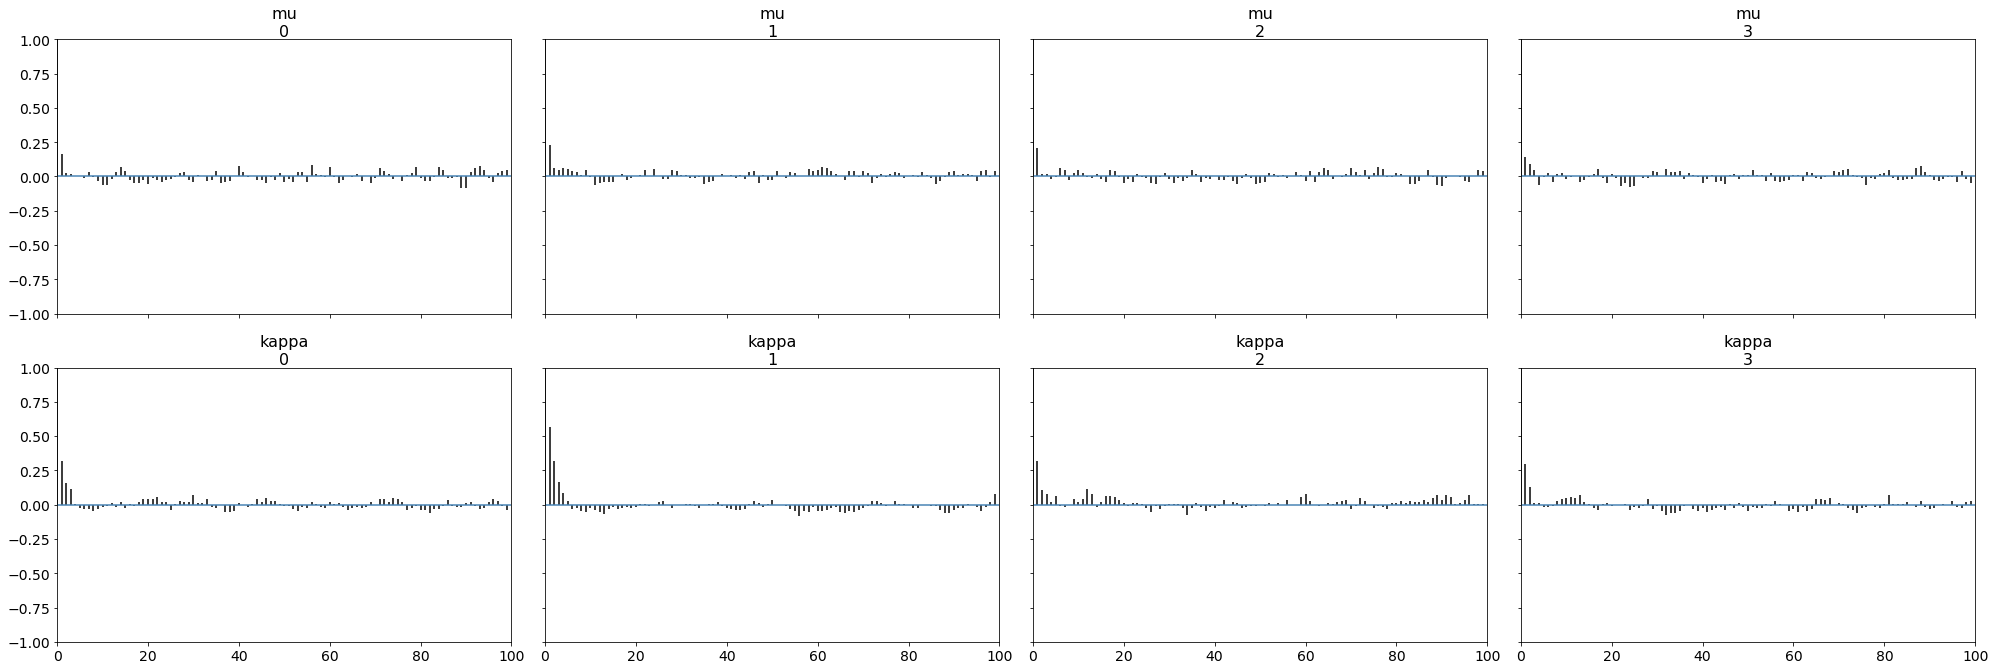

In [ ]:
az.plot_autocorr(az_infdata_obj)

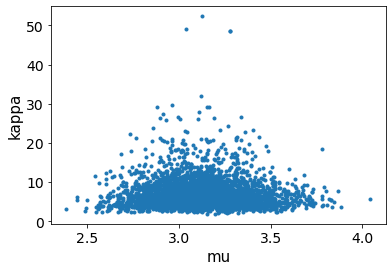

In [ ]:
az.plot_pair(az_infdata_obj)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f84b4c5a0f0>,
      dtype=object)

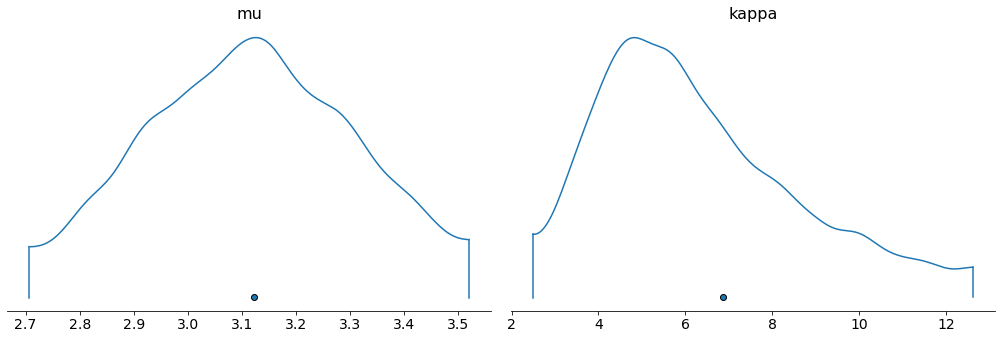

In [ ]:
az.plot_density(az_infdata_obj)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f84b3a09be0>,
      dtype=object)

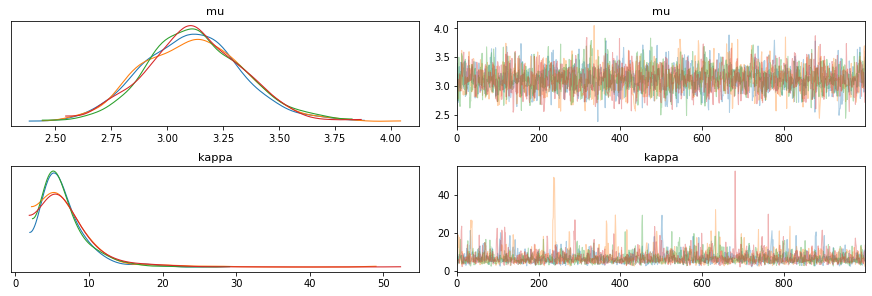

In [ ]:
az.plot_trace(az_infdata_obj)

In [ ]:
stan_sample.drop(columns=['lp__', 'accept_stat__','stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'mu','kappa'], inplace=True)

In [ ]:
posterior_checks_max =np.amax(stan_sample, axis=1)

In [ ]:
(posterior_checks_max >=12).sum()/float(len(posterior_checks_max))

0.24775

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


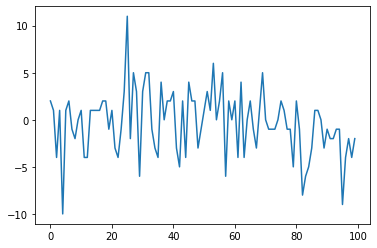

In [ ]:
(df.discoveries-stan_sample['XSim.1']).dropna().plot()

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([-0.01666667,  0.03596491,  0.0377193 ,  0.21842105,  0.14035088,
         0.01491228, -0.00175439,  0.04298246,  0.0754386 ,  0.10877193,
         1.        ,  0.10877193,  0.0754386 ,  0.04298246, -0.00175439,
         0.01491228,  0.14035088,  0.21842105,  0.0377193 ,  0.03596491,
        -0.01666667]),
 <matplotlib.lines.Line2D at 0x7f84b25e07f0>)

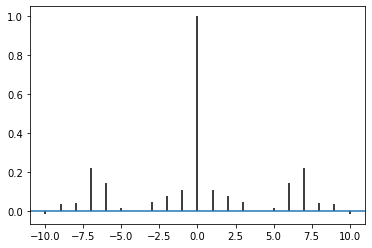

In [ ]:
plt.acorr((df.discoveries-stan_sample['XSim.1']).dropna())